In [1]:
# Import necessary libraries at the beginning of your notebook
import pandas as pd # Used for working with DataFrames (like spreadsheets)
import numpy as np  # Used for numerical operations, especially for creating random numbers
from sklearn.model_selection import train_test_split # Used to split data for training and testing
from sklearn.preprocessing import StandardScaler # Used for scaling numerical data
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix # Used to evaluate model performance
import xgboost as xgb # Our main AI model library
import matplotlib.pyplot as plt # Used for plotting graphs (like confusion matrix)
import seaborn as sns # Used for making plots look nicer

# --- Configuration for our fake (synthetic) data ---
NUM_SAMPLES = 1000 # We want to create 1000 rows of data. Each row is one "observation" or "data point".
NUM_FIRE_EVENTS = 50 # Out of these 1000 samples, we'll make 50 of them represent actual "fire" events.
                     # This is important because real fires are rare, so our data will be "imbalanced".

# --- Start Generating Synthetic Data ---
# We'll create a dictionary where each key is a column name and its value is a list of data for that column.
np.random.seed(42) # This line "seeds" the random number generator.
                   # It means that every time you run this code, you'll get the EXACT SAME random numbers.
                   # This is super useful for debugging and ensuring your results are consistent.

data = {
    # 'forest_grid_id': A unique identifier for a specific geographical grid area in the forest.
    # We're just creating simple IDs like 'grid_0', 'grid_1', etc.
    'forest_grid_id': [f'grid_{i // 10}' for i in range(NUM_SAMPLES)],

    # 'timestamp': The date and time when this data observation was recorded.
    # We're creating a sequence of hourly timestamps starting from Jan 1, 2024.
    'timestamp': pd.to_datetime('2024-01-01') + pd.to_timedelta(np.arange(NUM_SAMPLES), unit='h'),

    # 'avg_temp_c': Average temperature in Celsius.
    # np.random.uniform(15, 40, NUM_SAMPLES) generates 1000 random numbers
    # that are evenly distributed between 15 and 40.
    'avg_temp_c': np.random.uniform(15, 40, NUM_SAMPLES),

    # 'avg_humidity_rh': Average relative humidity (%).
    # Random numbers between 30% and 90%.
    'avg_humidity_rh': np.random.uniform(30, 90, NUM_SAMPLES),

    # 'avg_smoke_ppm': Average smoke concentration in parts per million (PPM).
    # Random numbers between 0 and 200.
    'avg_smoke_ppm': np.random.uniform(0, 200, NUM_SAMPLES),

    # 'avg_wind_speed_kmh': Average wind speed in kilometers per hour.
    # Random numbers between 0 and 30.
    'avg_wind_speed_kmh': np.random.uniform(0, 30, NUM_SAMPLES),

    # 'days_since_last_rain': Number of days since the last significant rainfall.
    # Random integers between 0 and 30.
    'days_since_last_rain': np.random.randint(0, 30, NUM_SAMPLES),

    # 'avg_ndvi': Normalized Difference Vegetation Index.
    # Lower values (e.g., 0.1-0.3) usually mean drier, less healthy vegetation.
    # Higher values (e.g., 0.7-0.9) mean greener, healthier vegetation.
    'avg_ndvi': np.random.uniform(0.1, 0.9, NUM_SAMPLES),

    # 'firms_hotspot_count': Number of active fire hotspots detected by satellite (FIRMS data).
    # Random integers between 0 and 5.
    'firms_hotspot_count': np.random.randint(0, 5, NUM_SAMPLES),

    # 'is_fire_event': This is our "target" variable. It's what we want our AI to predict.
    # '0' means no fire, '1' means fire.
    # We initially set all 1000 samples to '0' (no fire).
    'is_fire_event': np.zeros(NUM_SAMPLES, dtype=int) 
}

# Create a Pandas DataFrame from our 'data' dictionary.
# This organizes our data into rows and columns, like a spreadsheet.
df = pd.DataFrame(data)

# --- Now, let's inject some "fire" events and make their features look like fire conditions ---
# We randomly choose 50 unique indices (row numbers) from our 1000 samples.
fire_indices = np.random.choice(NUM_SAMPLES, NUM_FIRE_EVENTS, replace=False)

# For these chosen 50 rows, we set 'is_fire_event' to 1 (meaning a fire occurred).
df.loc[fire_indices, 'is_fire_event'] = 1 

# And crucially, for these 50 fire events, we make their feature values
# more typical of fire conditions (e.g., higher temperature, lower humidity, more smoke).
df.loc[fire_indices, 'avg_temp_c'] = np.random.uniform(35, 50, NUM_FIRE_EVENTS) # Higher temp
df.loc[fire_indices, 'avg_humidity_rh'] = np.random.uniform(10, 40, NUM_FIRE_EVENTS) # Lower humidity
df.loc[fire_indices, 'avg_smoke_ppm'] = np.random.uniform(150, 1000, NUM_FIRE_EVENTS) # Much higher smoke
df.loc[fire_indices, 'avg_wind_speed_kmh'] = np.random.uniform(20, 50, NUM_FIRE_EVENTS) # Higher wind
df.loc[fire_indices, 'days_since_last_rain'] = np.random.randint(15, 60, NUM_FIRE_EVENTS) # More days since rain
df.loc[fire_indices, 'avg_ndvi'] = np.random.uniform(0.05, 0.3, NUM_FIRE_EVENTS) # Lower NDVI (drier vegetation)
df.loc[fire_indices, 'firms_hotspot_count'] = np.random.randint(1, 10, NUM_FIRE_EVENTS) # Some hotspots

# Print some information to verify our data
print(f"Synthetic dataset created with {len(df)} samples (rows).")
print(f"Number of fire events (rows where 'is_fire_event' is 1): {df['is_fire_event'].sum()}")
print("\nFirst 5 rows of our synthetic data:")
print(df.head()) # This command shows you the first 5 rows of your DataFrame.

Synthetic dataset created with 1000 samples (rows).
Number of fire events (rows where 'is_fire_event' is 1): 50

First 5 rows of our synthetic data:
  forest_grid_id           timestamp  avg_temp_c  avg_humidity_rh  \
0         grid_0 2024-01-01 00:00:00   24.363503        41.107976   
1         grid_0 2024-01-01 01:00:00   38.767858        62.514057   
2         grid_0 2024-01-01 02:00:00   33.299849        82.376750   
3         grid_0 2024-01-01 03:00:00   29.966462        73.933493   
4         grid_0 2024-01-01 04:00:00   45.156407        22.241214   

   avg_smoke_ppm  avg_wind_speed_kmh  days_since_last_rain  avg_ndvi  \
0      52.341137           20.181090                     9  0.557698   
1      49.395760           23.900442                    20  0.244628   
2     181.250916            7.514037                     4  0.315038   
3      49.909240           18.746223                    26  0.258916   
4     684.836314           28.016297                    43  0.209847   

   

In [2]:
# Define the list of column names that will be our 'features' (inputs to the AI).
# These are the environmental factors we believe influence wildfire risk.
features = [
    'avg_temp_c', 'avg_humidity_rh', 'avg_smoke_ppm', 'avg_wind_speed_kmh',
    'days_since_last_rain', 'avg_ndvi', 'firms_hotspot_count'
]

# Define the 'target' variable (the output our AI will predict).
# In our case, it's whether a fire event occurred (1) or not (0).
target = 'is_fire_event'

# Create our input data (X) by selecting only the 'features' columns from our DataFrame 'df'.
X = df[features] 

# Create our output data (y) by selecting only the 'target' column from our DataFrame 'df'.
y = df[target]   

print("\nFirst 5 rows of our Features (X) - these are the inputs for the AI:")
print(X.head())
print("\nFirst 5 values of our Target (y) - this is what the AI will try to predict:")
print(y.head())


First 5 rows of our Features (X) - these are the inputs for the AI:
   avg_temp_c  avg_humidity_rh  avg_smoke_ppm  avg_wind_speed_kmh  \
0   24.363503        41.107976      52.341137           20.181090   
1   38.767858        62.514057      49.395760           23.900442   
2   33.299849        82.376750     181.250916            7.514037   
3   29.966462        73.933493      49.909240           18.746223   
4   45.156407        22.241214     684.836314           28.016297   

   days_since_last_rain  avg_ndvi  firms_hotspot_count  
0                     9  0.557698                    2  
1                    20  0.244628                    1  
2                     4  0.315038                    1  
3                    26  0.258916                    2  
4                    43  0.209847                    3  

First 5 values of our Target (y) - this is what the AI will try to predict:
0    0
1    0
2    0
3    0
4    1
Name: is_fire_event, dtype: int64


In [3]:
# Split data into training and testing sets
# X: our input features
# y: our target variable
# test_size=0.2: This means 20% of our data will be allocated for the testing set, and 80% for training.
# random_state=42: Ensures that every time you run this code, the data is split in the exact same way.
# stratify=y: This is crucial! It ensures that the proportion of 'fire' events (1s)
# in the training set is roughly the same as in the testing set.
# This prevents scenarios where, by chance, all fire events end up in only one set.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"\nTraining set size: {len(X_train)} samples (rows)")
print(f"Testing set size: {len(X_test)} samples (rows)")
print(f"Number of fire events in training set: {y_train.sum()} ({y_train.sum()/len(y_train)*100:.2f}%)")
print(f"Number of fire events in testing set: {y_test.sum()} ({y_test.sum()/len(y_test)*100:.2f}%)")


Training set size: 800 samples (rows)
Testing set size: 200 samples (rows)
Number of fire events in training set: 40 (5.00%)
Number of fire events in testing set: 10 (5.00%)


In [4]:
# Initialize StandardScaler: This creates an "empty" scaler object.
scaler = StandardScaler()

# Fit the scaler ONLY on the training data and then transform the training data.
# 'fit' means the scaler learns the mean and standard deviation from X_train.
# 'transform' means it applies that learning to scale the data.
# IMPORTANT: We ONLY 'fit' on X_train. We never 'fit' on X_test or the whole dataset.
# This is because X_test must remain truly "unseen" by any part of the learning process.
X_train_scaled = scaler.fit_transform(X_train)

# Now, use the *SAME* scaler (which has already learned from X_train) to transform X_test.
# We only call 'transform' here, not 'fit_transform'.
X_test_scaled = scaler.transform(X_test)

# Convert the scaled NumPy arrays back into Pandas DataFrames.
# This makes it easier to inspect the data and keeps the column names.
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=features, index=X_train.index)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=features, index=X_test.index)

print("\nFirst 5 rows of our Scaled Training Features (X_train_scaled_df):")
print(X_train_scaled_df.head())
# Observe: The numbers will now be centered around 0, and their ranges will be similar.


First 5 rows of our Scaled Training Features (X_train_scaled_df):
     avg_temp_c  avg_humidity_rh  avg_smoke_ppm  avg_wind_speed_kmh  \
882   -1.581180         0.522077      -0.631501            1.336350   
82    -0.599688        -0.172745      -0.258116           -1.049781   
838    0.187840         1.449073       0.173737            1.259384   
158   -0.893834         1.270404      -0.277858            0.915098   
185    0.438255         1.478125       0.431469            0.001720   

     days_since_last_rain  avg_ndvi  firms_hotspot_count  
882             -0.518093  0.672336            -0.685921  
82               1.091907 -0.503743            -1.312332  
838             -0.618718  0.414438             1.193314  
158             -0.417468 -1.178581            -1.312332  
185             -1.624968  0.889463            -1.312332  


In [5]:
# Initialize XGBoost Classifier for binary classification
# We are building a 'classifier' because we want to classify between two outcomes: fire (1) or no fire (0).

# First, calculate 'scale_pos_weight'. This is CRUCIAL for our imbalanced data!
# It tells XGBoost to give more importance to the rare 'fire' events.
# Formula: (number of 'no fire' examples) / (number of 'fire' examples)
scale_pos_weight_value = (y_train == 0).sum() / (y_train == 1).sum()
print(f"\nCalculated scale_pos_weight: {scale_pos_weight_value:.2f}")
# You'll see a number much larger than 1 (e.g., 19.00), meaning 'fire' events are weighted 19 times more.

xgb_model = xgb.XGBClassifier(
    objective='binary:logistic', # This tells XGBoost we're doing binary classification (0 or 1).
                                 # 'logistic' refers to logistic regression, which outputs probabilities.
    eval_metric='logloss',       # This is the metric XGBoost uses internally to evaluate itself during training.
                                 # 'logloss' (logarithmic loss) is a common metric for binary classification.
    use_label_encoder=False,     # This just suppresses a warning message in newer XGBoost versions.
                                 # It's related to how categorical labels are handled internally.
    n_estimators=100,            # This is the number of "mini-detectives" (decision trees) in our team.
                                 # 100 is a good starting point. More can be better but also slower.
    learning_rate=0.1,           # This controls how much each new "mini-detective" corrects the errors.
                                 # A smaller learning rate means more cautious corrections, often leading
                                 # to a more robust model, but requiring more estimators.
    random_state=42,             # Ensures that every time you train the model, the internal random processes
                                 # are the same, leading to consistent results.
    scale_pos_weight=scale_pos_weight_value # Apply the calculated weight to handle data imbalance.
                                          # This makes the model pay more attention to the 'fire' class.
)

# Train the model!
# This is where the magic happens. The model 'fits' itself to the training data.
print("\nStarting XGBoost model training...")
xgb_model.fit(X_train_scaled, y_train) # X_train_scaled are the inputs, y_train are the correct answers.
print("XGBoost model training complete.")


Calculated scale_pos_weight: 19.00

Starting XGBoost model training...
XGBoost model training complete.


C:\Users\annac\OneDrive\Desktop\projects\Foresight-for-Forests\foresight_ai_env_py310\lib\site-packages\xgboost\training.py:183: UserWarning: [20:16:43] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [6]:
# Predict probabilities: This gives us a confidence score (0 to 1) for each prediction.
# We take the second column (index 1) because it's the probability of the positive class (fire=1).
y_pred_proba = xgb_model.predict_proba(X_test_scaled)[:, 1] 

# Predict class labels: This gives us the final prediction (0 or 1).
y_pred = xgb_model.predict(X_test_scaled) 

print("\nSample predicted probabilities (first 10 test samples):")
print(y_pred_proba[:10]) # Shows the probability scores for the first 10 test samples.
print("\nSample predicted classes (first 10 test samples):")
print(y_pred[:10])       # Shows the 0 or 1 prediction for the first 10 test samples.


Sample predicted probabilities (first 10 test samples):
[6.8110682e-04 7.2011637e-04 9.9922550e-01 7.6595333e-04 2.3900706e-03
 7.6595333e-04 9.6437533e-04 7.1343797e-04 6.8110682e-04 1.0844707e-03]

Sample predicted classes (first 10 test samples):
[0 0 1 0 0 0 0 0 0 0]



--- Model Evaluation Metrics ---
Accuracy:  0.9950
Precision: 1.0000
Recall:    0.9000
F1-Score:  0.9474
ROC AUC:   1.0000

Confusion Matrix (values are counts):
[[190   0]
 [  1   9]]


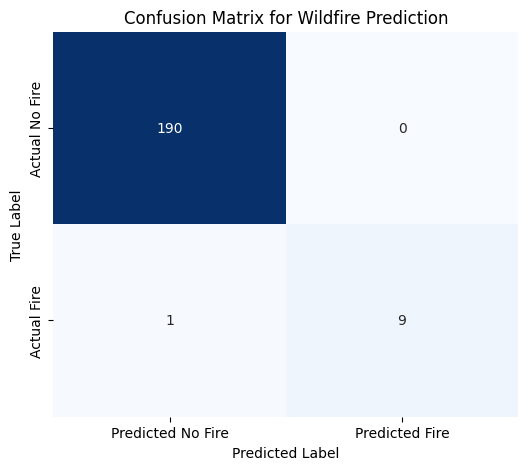

In [7]:
# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)       # Overall correctness
precision = precision_score(y_test, y_pred)     # Of predicted fires, how many were actual fires?
recall = recall_score(y_test, y_pred)           # Of actual fires, how many did we catch?
f1 = f1_score(y_test, y_pred)                   # Balance of precision and recall
roc_auc = roc_auc_score(y_test, y_pred_proba)   # Ability to distinguish classes

cm = confusion_matrix(y_test, y_pred)           # The detailed breakdown of predictions

print(f"\n--- Model Evaluation Metrics ---")
print(f"Accuracy:  {accuracy:.4f}")  # Formatted to 4 decimal places
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")
print(f"ROC AUC:   {roc_auc:.4f}")

print("\nConfusion Matrix (values are counts):")
print(cm)
# Interpretation of Confusion Matrix:
# The matrix looks like this:
# [[True Negatives (TN), False Positives (FP)]
#  [False Negatives (FN), True Positives (TP)]]
# Example: cm[0,0] is TN, cm[0,1] is FP, cm[1,0] is FN, cm[1,1] is TP

# Visualize Confusion Matrix (optional, but highly recommended for clear understanding)
plt.figure(figsize=(6, 5)) # Sets the size of the plot
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted No Fire', 'Predicted Fire'], # Labels for predicted classes
            yticklabels=['Actual No Fire', 'Actual Fire'])       # Labels for actual classes
plt.xlabel('Predicted Label') # Label for the X-axis
plt.ylabel('True Label')      # Label for the Y-axis
plt.title('Confusion Matrix for Wildfire Prediction') # Title of the plot
plt.show() # Displays the plot